# Bayesian Estimation of Differential Equations

Most of the scientific community deals with the basic problem of trying to mathematically model the reality around them and this often involves dynamical systems. The general trend to model these complex dynamical systems is through the use of differential equations. Differential equation models often have non-measurable parameters. The popular “forward-problem” of simulation consists of solving the differential equations for a given set of parameters, the “inverse problem” to simulation, known as parameter estimation, is the process of utilizing data to determine these model parameters. Bayesian inference provides a robust approach to parameter estimation with quantified uncertainty.

In [1]:
using Pkg; Pkg.activate(".")

 Activating environment at `~/TuringTutorials/Project.toml`


In [2]:
using Turing, Distributions, DifferentialEquations 

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

# Disable Turing's progress meter for this tutorial.
Turing.turnprogress(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/vaibhavdixit/.julia/packages/Turing/GMBTf/src/Turing.jl:22


false

## The Lotka-Volterra Model

The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The populations change through time according to the pair of equations:

$\frac{dx}{dt} = (\alpha - \beta y)x$
 
$\frac{dy}{dt} = (\delta x - \gamma)y$


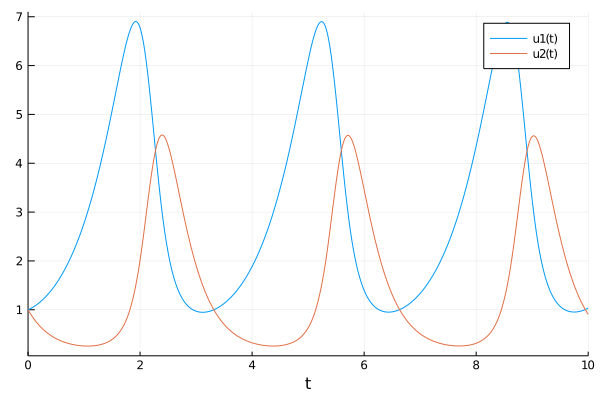

In [3]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, γ, δ  = p
  du[1] = (α - β*y)x # dx =
  du[2] = (δ*x - γ)y # dy = 
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob1 = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob1,Tsit5())
plot(sol)

We'll generate the data to use for the parameter estimation from simulation. 
With the `saveat` [argument](https://docs.sciml.ai/latest/basics/common_solver_opts/) we specify that the solution is stored only at `0.1` time units. To make the data look more realistic, we add random noise using the function `randn`.

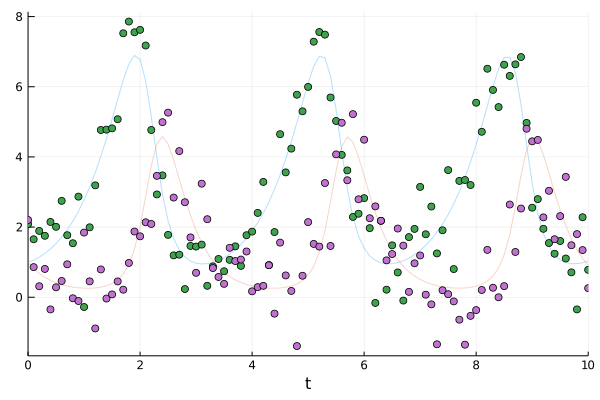

In [4]:
sol1 = solve(prob1,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

## Direct Handling of Bayesian Estimation with Turing

Previously, functions in Turing and DifferentialEquations were not inter-composable, so Bayesian inference of differential equations needed to be handled by another package called [DiffEqBayes.jl](https://github.com/SciML/DiffEqBayes.jl) (note that DiffEqBayes works also with CmdStan.jl, Turing.jl, DynamicHMC.jl and ApproxBayes.jl - see the [DiffEqBayes docs](https://docs.sciml.ai/latest/analysis/parameter_estimation/#Bayesian-Methods-1) for more info).

From now on however, Turing and DifferentialEquations are completely composable and we can write of the differential equation inside a Turing `@model` and it will just work. Therefore, we can rewrite the Lotka Volterra parameter estimation problem with a Turing `@model` interface as below:

In [5]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata)

# This next command runs 3 independent chains without using multithreading. 
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/vaibhavdixit/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.juli

Object of type Chains, with data of type 500×17×3 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.5557  0.0527    0.0014  0.0028  340.9160  1.0030
           β  1.0915  0.0537    0.0014  0.0027  412.4381  1.0006
           γ  2.8793  0.1400    0.0036  0.0071  344.1136  1.0032
           δ  0.9390  0.0500    0.0013  0.0025  345.3194  1.0034
           σ  0.8132  0.0417    0.0011  0.0019  639.2399  1.0007

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────

The estimated parameters are close to the desired parameter values. We can also check that the chains have converged in the plot.

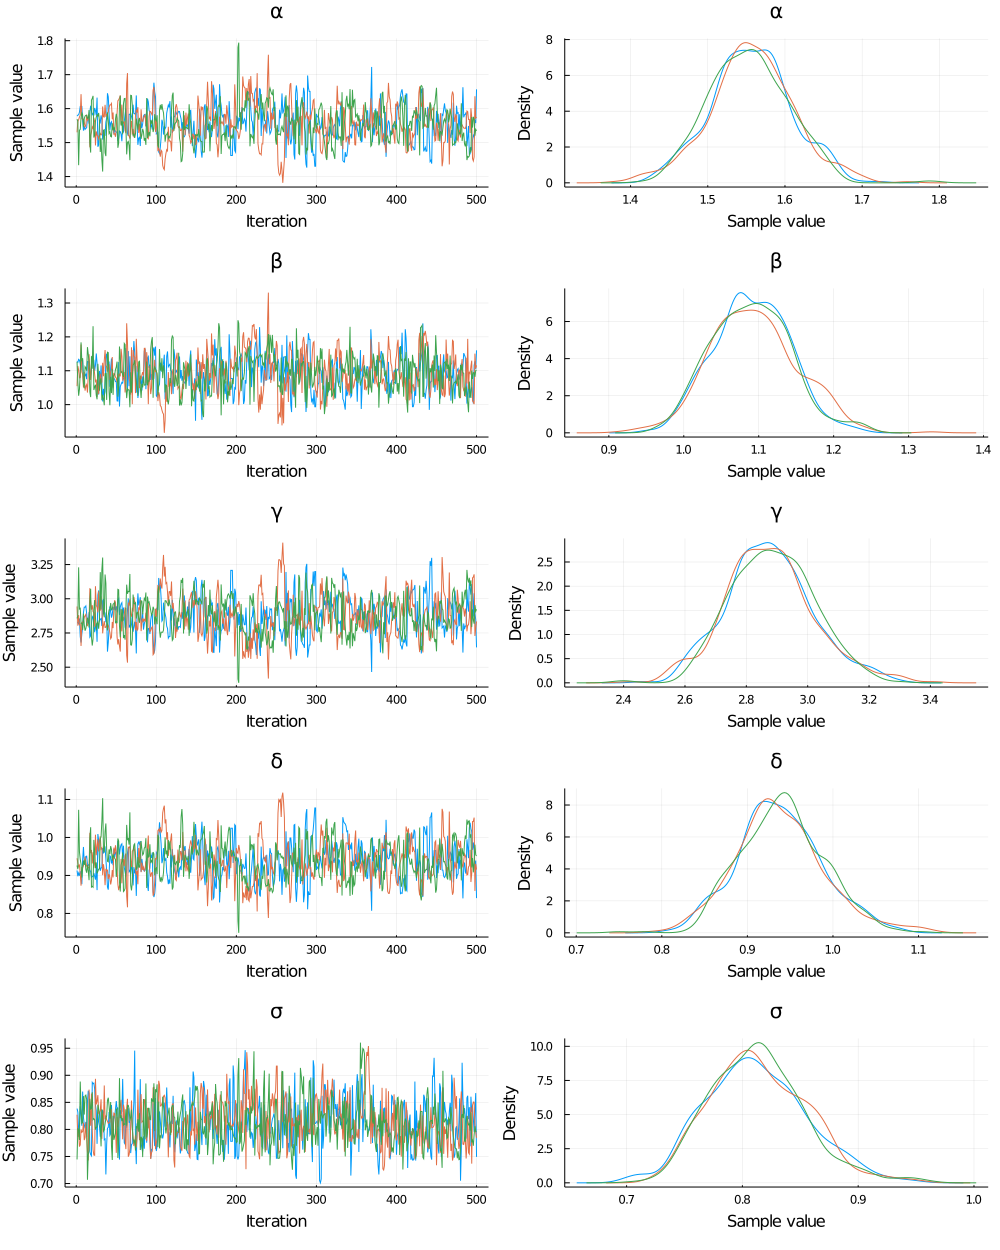

In [6]:
plot(chain)

### Data retrodiction 
In Bayesian analysis it is often useful to retrodict the data, i.e. generate simulated data using samples from the posterior distribution, and compare to the original data (see for instance section 3.3.2 - model checking of McElreath's book "Statistical Rethinking"). Here, we solve again the ODE using the output in `chain`, for 300 randomly picked posterior samples. We plot this ensemble of solutions to check if the solution resembles the data. 

In [7]:
pl = scatter(sol1.t, odedata');

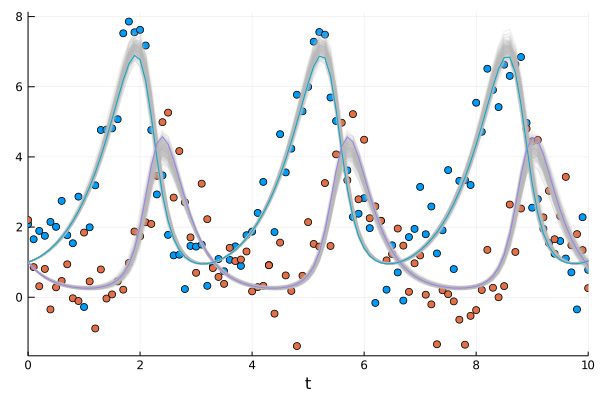

In [8]:
chain_array = Array(chain)
for k in 1:300 
    resol = solve(remake(prob1,p=chain_array[rand(1:1500), 1:4]),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
# display(pl)
plot!(sol1, w=1, legend = false)

In the plot above, the 300 retrodicted time courses from the posterior are plotted in gray, and the original data are the blue and red dots, and the solution that was used to generate the data are the green and purple lines. We can see that, even though we added quite a bit of noise to the data (see dot plot above), the posterior distribution reproduces quite accurately the "true" ODE solution.

## Lokta Volterra with missing predator data

Thanks to the known structure of the problem, encoded by the Lokta-Volterra ODEs, one can also fit a model with incomplete data - even without any data for one of the two variables. For instance, let's suppose you have observations for the prey only, but none for the predator. We test this case by fitting the model only to the $y$ variable of the system, without providing any data for $x$:

In [9]:
@model function fitlv2(data) # data should be a Vector
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i][2], σ) # predicted[i][2] is the data for y - a scalar, so we use Normal instead of MvNormal
    end
end

model2 = fitlv2(odedata[2,:])

DynamicPPL.Model{var"###evaluator#333",(:data,),Tuple{Array{Float64,1}},(),DynamicPPL.ModelGen{var"###generator#334",(:data,),(),Tuple{}}}(##evaluator#333, (data = [2.200730590544725, 0.8584002186440604, 0.3130803892338444, 0.8065538543184622, -0.34719524379658445, 0.2827563462601055, 0.4633732909134419, 0.9388139946097072, -0.029638888419957155, -0.10766570796447744  …  4.484466907306791, 2.276637854709268, 3.034635398109261, 1.6534146147281914, 2.3126757947633125, 3.430419239300897, 1.481768351221498, 1.7989355388635417, 1.343881963121325, 0.25843622408034905],), DynamicPPL.ModelGen{var"###generator#334",(:data,),(),Tuple{}}(##generator#334, NamedTuple()))

Here we use the multithreading functionality [available](https://turing.ml/dev/docs/using-turing/guide#multithreaded-sampling) in Turing.jl to sample 3 independent chains

In [10]:
Threads.nthreads()

4

In [11]:
# This next command runs 3 independent chains with multithreading. 
chain2 = sample(model2, NUTS(.45), MCMCThreads(), 5000, 3, progress=true)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/vaibhavdixit/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.jul

Object of type Chains, with data of type 4000×17×3 Array{Float64,3}

Iterations        = 1:4000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 4000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.5704  0.1824    0.0017  0.0110  137.4447  1.0113
           β  1.1272  0.1447    0.0013  0.0085  142.0610  1.0107
           γ  2.9492  0.2847    0.0026  0.0163  176.9375  1.0097
           δ  0.9356  0.2369    0.0022  0.0138  152.8364  1.0117
           σ  0.8232  0.0563    0.0005  0.0032  140.6188  1.0145

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ───

In [12]:
size(chain2, 1)

4000

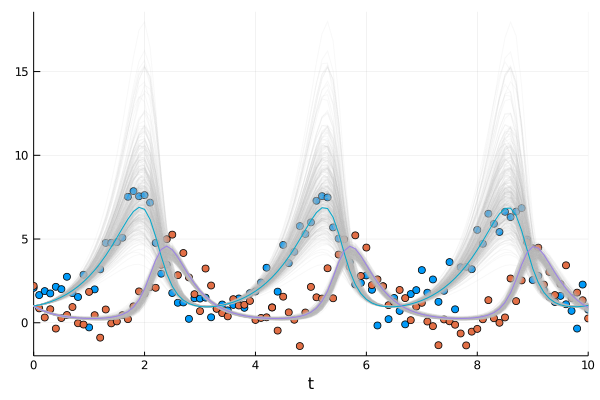

In [13]:
pl = scatter(sol1.t, odedata');
chain_array2 = Array(chain2)
for k in 1:300 
    resol = solve(remake(prob1,p=chain_array2[rand(1:12000), 1:4]),Tsit5(),saveat=0.1) 
    # Note that due to a bug in AxisArray, the variables from the chain will be returned always in
    # the order it is stored in the array, not by the specified order in the call - :α, :β, :γ, :δ
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
#display(pl)
plot!(sol1, w=1, legend = false)

Note that here, the data values of $x$ (blue dots) were not given to the model! Yet, the model could predict the values of $x$ relatively accurately, albeit with a wider distribution of solutions, reflecting the greater uncertainty in the prediction of the $x$ values.

## Inference of Delay Differential Equations

Here we show an example of inference with another type of differential equation: a Delay Differential Equation (DDE). A DDE is an DE system where derivatives are function of values at an earlier point in time. This is useful to model a delayed effect, like incubation time of a virus for instance. 

For this, we will define a [`DDEProblem`](https://diffeq.sciml.ai/stable/tutorials/dde_example/), from the package DifferentialEquations.jl. 

Here is a delayed version of the lokta voltera system:

$\frac{dx}{dt} = \alpha x(t-\tau) - \beta y(t) x(t)$
 
$\frac{dy}{dt} = - \gamma y(t) + \delta x(t) y(t) $

Where $x(t-\tau)$ is the variable $x$ at an earlier time point. We specify the delayed variable with a function `h(p, t)`, as described in the [DDE example](https://diffeq.sciml.ai/stable/tutorials/dde_example/).

In [14]:
function delay_lotka_volterra(du,u,h,p,t)
    x, y = u
    α,β,γ,δ = p
    du[1] = α*h(p,t-1)[1] - β*x*y
    du[2] = -γ*y + δ*x*y
end

p = (1.5,1.0,3.0,1.0); u0 = [1.0;1.0]
tspan = (0.0,10.0)
h(p,t) = 1.0
prob1 = DDEProblem(delay_lotka_volterra,u0,h,tspan,p)

DDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

In [15]:
sol = solve(prob1,saveat=0.1)
ddedata = Array(sol)
ddedata = ddedata + 0.5 * randn(size(ddedata))

2×101 Array{Float64,2}:
  1.95015   1.1012    0.938594  …  2.88359  3.88143  3.25962   2.80738
 -0.428178  0.693854  0.944046     2.36939  1.94306  0.999657  2.13677

Plot the data:

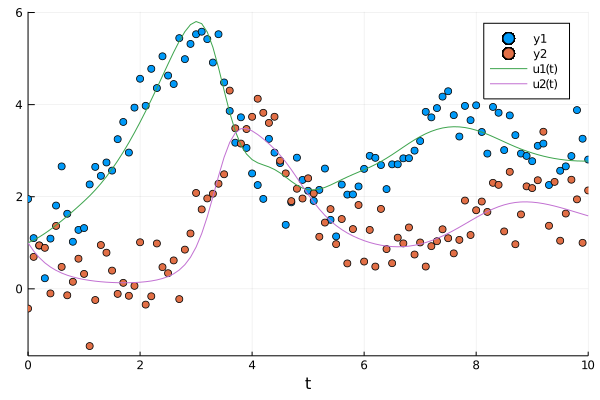

In [16]:
scatter(sol.t, ddedata'); plot!(sol)

Now we define and run the Turing model. 

In [17]:
Turing.setadbackend(:forwarddiff)
@model function fitlv(data)
    
    σ ~ InverseGamma(2, 3)
    α ~ Truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ Truncated(Normal(1.2,0.5),0,2)
    γ ~ Truncated(Normal(3.0,0.5),1,4)
    δ ~ Truncated(Normal(1.0,0.5),0,2)
    
    p = [α,β,γ,δ]
    
    #prob = DDEProblem(delay_lotka_volterra,u0,_h,tspan,p)
    prob = remake(prob1, p=p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(ddedata)

DynamicPPL.Model{var"###evaluator#417",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#418",(:data,),(),Tuple{}}}(##evaluator#417, (data = [1.950151269970946 1.1012009481956744 … 3.2596243979896546 2.8073795220348914; -0.42817779725188676 0.6938535469441495 … 0.9996569502656769 2.136773691914533],), DynamicPPL.ModelGen{var"###generator#418",(:data,),(),Tuple{}}(##generator#418, NamedTuple()))

Then we draw samples using multithreading; this time, we draw 3 independent chains in parallel using `MCMCThreads`.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/vaibhavdixit/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629


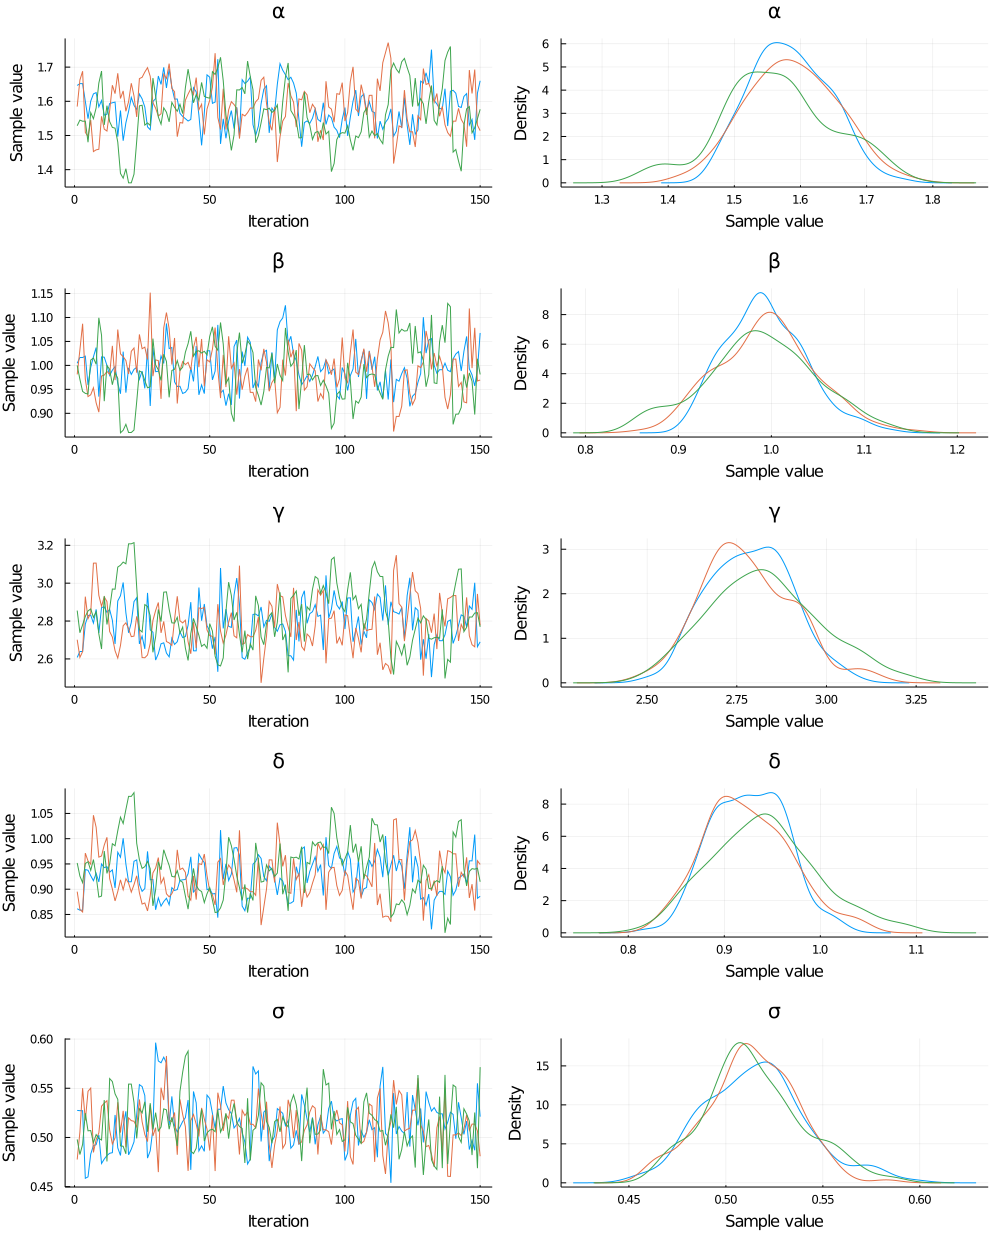

In [18]:
chain = sample(model, NUTS(.65), MCMCThreads(), 300, 3, progress=true)
plot(chain)

Finally, we select a 100 sets of parameters from the first chain and plot solutions.

In [19]:
chain

Object of type Chains, with data of type 150×17×3 Array{Float64,3}

Iterations        = 1:150
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 150
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.5787  0.0721    0.0034  0.0068  105.1689  1.0077
           β  0.9922  0.0516    0.0024  0.0037  130.5338  0.9976
           γ  2.7984  0.1344    0.0063  0.0133  112.2369  1.0138
           δ  0.9305  0.0473    0.0022  0.0049  105.1380  1.0125
           σ  0.5143  0.0248    0.0012  0.0013  333.2133  0.9983

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────

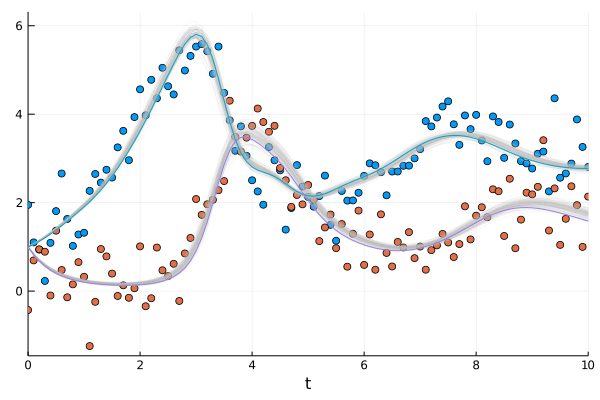

In [20]:
pl = scatter(sol.t, ddedata')
chain_array = Array(chain) 
for k in 1:100
    
    resol = solve(remake(prob1,p=chain_array[rand(1:450),1:4]),Tsit5(),saveat=0.1)
    # Note that due to a bug in AxisArray, the variables from the chain will be returned always in
    # the order it is stored in the array, not by the specified order in the call - :α, :β, :γ, :δ
    
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
#display(pl)
plot!(sol)

Here again, the dots is the data fed to the model, the continuous colored line is the "true" solution, and the gray lines are solutions from the posterior. The fit is pretty good even though the data was quite noisy to start.

## Scaling to Large Models: Adjoint Sensitivities

DifferentialEquations.jl's efficiency for large stiff models has been shown in multiple [benchmarks](https://github.com/SciML/DiffEqBenchmarks.jl). To learn more about how to optimize solving performance for stiff problems you can take a look at the [docs](https://docs.sciml.ai/latest/tutorials/advanced_ode_example/). 

[Sensitivity analysis](https://docs.sciml.ai/latest/analysis/sensitivity/), or automatic differentiation (AD) of the solver, is provided by the DiffEq suite. The model sensitivities are the derivatives of the solution $u(t)$ with respect to the parameters. Specifically, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter. Sensitivity analysis provides a cheap way to calculate the gradient of the solution which can be used in parameter estimation and other optimization tasks.


The AD ecosystem in Julia allows you to switch between forward mode, reverse mode, source to source and other choices of AD and have it work with any Julia code. For a user to make use of this within [SciML](https://sciml.ai), [high level interactions in `solve`](https://docs.sciml.ai/latest/analysis/sensitivity/#High-Level-Interface:-sensealg-1) automatically plug into those AD systems to allow for choosing advanced sensitivity analysis (derivative calculation) [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1). 

More theoretical details on these methods can be found at: https://docs.sciml.ai/latest/extras/sensitivity_math/.

While these sensitivity analysis methods may seem complicated (and they are!), using them is dead simple. Here is a version of the Lotka-Volterra model with adjoints enabled.

All we had to do is switch the AD backend to one of the adjoint-compatible backends (ReverseDiff, Tracker, or Zygote) and boom the system takes over and we're using adjoint methods! Notice that on this model adjoints are slower. This is because adjoints have a higher overhead on small parameter models and we suggest only using these methods for models with around 100 parameters or more. For more details, see https://arxiv.org/abs/1812.01892.

In [21]:
using Zygote, DiffEqSensitivity
Turing.setadbackend(:zygote)
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/vaibhavdixit/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.juli

Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.2556  0.0822    0.0037  0.0090   88.5274  1.0212
           β  0.8769  0.1056    0.0047  0.0061  152.6190  1.0135
           γ  1.0922  0.0955    0.0043  0.0108   93.9549  1.0138
           δ  0.5369  0.0565    0.0025  0.0060  109.2372  1.0140
           σ  2.0539  0.1064    0.0048  0.0049  173.6449  1.0081

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

Now we can exercise control of the sensitivity analysis method that is used by using the `sensealg` keyword argument. Let's choose the `InterpolatingAdjoint` from the available AD [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1) and enable a compiled ReverseDiff vector-Jacobian product:

In [22]:
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1,sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)))
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
@time chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/vaibhavdixit/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.ju

187.587922 seconds (1.23 G allocations: 69.351 GiB, 8.40% gc time)


Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.2570  0.0758    0.0034  0.0034  167.5210  0.9981
           β  0.8897  0.1157    0.0052  0.0107  177.7335  0.9983
           γ  1.0922  0.0812    0.0036  0.0049  119.3555  0.9993
           δ  0.5360  0.0500    0.0022  0.0033  132.2755  0.9988
           σ  2.0580  0.1024    0.0046  0.0086  189.4302  1.0069

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

For more examples of adjoint usage on large parameter models, consult the [DiffEqFlux documentation](https://diffeqflux.sciml.ai/dev/).

## Inference of a Stochastic Differential Equation
A Stochastic Differential Equation ([SDE](https://diffeq.sciml.ai/stable/tutorials/sde_example/)) is a differential equation that has a stochastic (noise) term in the expression of the derivatives. Here we fit a Stochastic version of the Lokta-Volterra system.

We use a quasi-likelihood approach in which all trajectories of a solution are compared instead of a reduction such as mean, this increases the robustness of fitting and makes the likelihood more identifiable. We use SOSRI to solve the equation. The NUTS sampler is a bit sensitive to the stochastic optimization since the gradient is then changing with every calculation, so we use NUTS with a target acceptance rate of `0.25`.

 14.408065 seconds (53.33 M allocations: 4.900 GiB, 8.75% gc time)


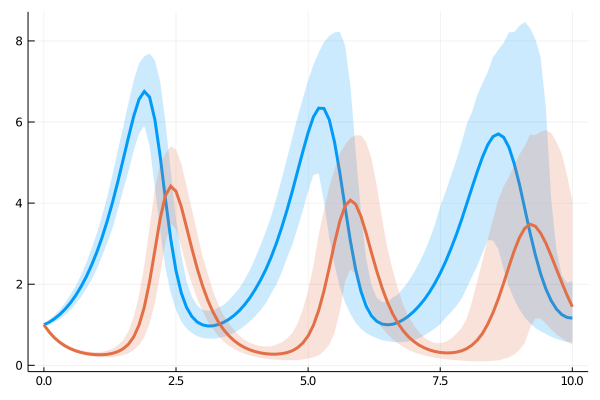

In [23]:
function lotka_volterra!(du,u,p,t)
  x,y = u
  α,β,γ,δ = p
  du[1] = dx = α*x - β*x*y
  du[2] = dy = δ*x*y - γ*y
end
u0 = [1.0,1.0]
tspan = (0.0,10.0)
function multiplicative_noise!(du,u,p,t)
  x,y = u
  du[1] = p[5]*x
  du[2] = p[6]*y
end
p = [1.5,1.0,3.0,1.0,0.1,0.1]
prob = SDEProblem(lotka_volterra!,multiplicative_noise!,u0,tspan,p)
ensembleprob = EnsembleProblem(prob)
@time data = solve(ensembleprob,SOSRI(),saveat=0.1,trajectories=1000)
plot(EnsembleSummary(data))

In [24]:
Turing.setadbackend(:forwarddiff)
@model function fitlv(data)
    σ ~ InverseGamma(2,3)
    α ~ truncated(Normal(1.3,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.25),0.5,2)
    γ ~ truncated(Normal(3.2,0.25),2.2,4.0)
    δ ~ truncated(Normal(1.2,0.25),0.5,2.0)
    ϕ1 ~ truncated(Normal(0.12,0.3),0.05,0.25)
    ϕ2 ~ truncated(Normal(0.12,0.3),0.05,0.25)
    p = [α,β,γ,δ,ϕ1,ϕ2]
    prob = SDEProblem(lotka_volterra!,multiplicative_noise!,u0,(0.0,10.0),p)
    predicted = solve(prob,SOSRI(),saveat=0.1)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data)
        for i = 1:length(predicted)
            data[j][i] ~ MvNormal(predicted[i],σ)
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/vaibhavdixit/.julia/packages/DynamicPPL/MRwtL/src/compiler.jl:181


We use NUTS sampler with a low acceptance ratio and initial parameters since estimating the parameters of SDE with HMC poses a challenge. Probabilistic nature of the SDE solution makes the likelihood function noisy which poses a challenge for NUTS since the gradient is then changing with every calculation. SGHMC might be better suited to be used here.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/vaibhavdixit/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0026680213783972003
└ @ Turing.Inference /User

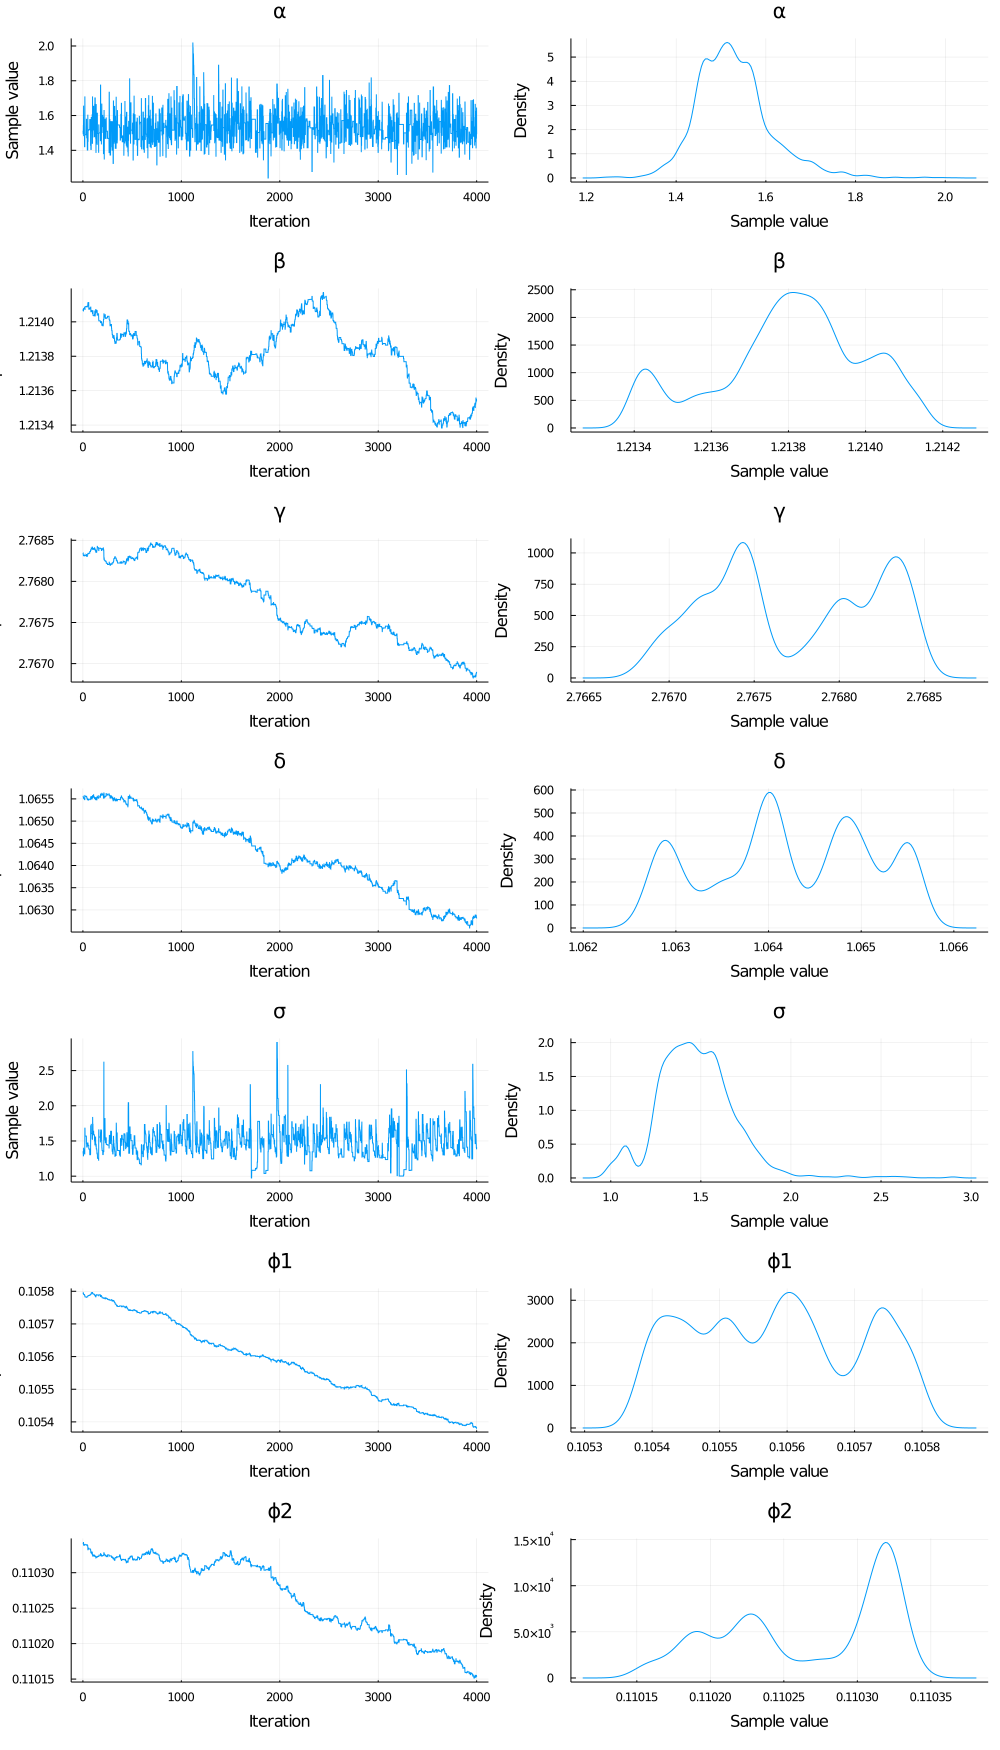

In [25]:
model = fitlv(data)
chain = sample(model, NUTS(0.25), 5000, init_theta = [1.5,1.3,1.2,2.7,1.2,0.12,0.12])
plot(chain)